## This notebook demonstrates calibrating MWR to the S-1000, 2022 landslide using the calibrator utility

### import landlab raster model grid and other python packages needed for running and visualizing the model

In [1]:
#TO DO: change so that calibrator saves model run and lines, then access after is run to create videos
#       create tool for picking profile location, additional function of calibrator  

import os

## import plotting tools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sc

## import necessary landlab components
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator
from landlab.components import(FlowDirectorD8, 
                                FlowDirectorMFD)

from landlab.components.mass_wasting_router import MassWastingRunout

## import landlab plotting functionality
from landlab import imshow_grid_at_node

## import functions
from landlab.io.esri_ascii import write_esri_ascii
from landlab.io import read_esri_ascii

from landlab.components import ChannelProfiler, FlowAccumulator, DepressionFinderAndRouter


os.chdir('C:/Users/keckje/Documents/GitHub/landlab/landlab/components/mass_wasting_router/')
from mwru_calibrator_working_copy import (MWRu_calibrator,
                                profile_distance,
                                profile_plot,
                                view_profile_nodes)

os.chdir('C:/Users/keckje/Documents/GitHub/code/preevents/paper2/')
import MassWastingRunoutEvaluationFunctions as MWF

# load plotting functions
os.chdir('C:/Users/keckje/Documents/GitHub/landlab/notebooks/tutorials/landslides')
python_file = open("imshow_grid_at_node_with_alpha.txt").read()
exec(python_file)

### import other custom plotting code and functions

### DEFINE parameter range from which calibrator will search for the optimal parameter values

In [2]:
#%% input
svnm = 's1000_10m_10_ns_n'

# average thickness of landslide
mw_id = 1
UseSoilDepth = True
t_avg = 15
vary_cs = False
qsc_constraint = True
method = "both"
routing_surface = "topographic__elevation"
deposition_rule = "critical_slope"
deposit_style = 'downslope_deposit_sc10'
effective_qsi = True
qsi_max = 5
settle_deposit = False

g_erosion = True
Pd = 0.316

jump_size = 0.09
alpha_max = 0.7
alpha_min = 0.3#alpha_max-0.4
N_cycles = 100


# parameters for estimating alpha
h = 2
s = 0.25
ros = 2650
vs = 0.6
eta = 0.2


####
# calibration parameters
# min, max and best estimate of flux threshold and scour coefficient
if vary_cs:
    params = {'SD':[0.01,0.75,0.3],
              'slpc':[0.005, 0.07, 0.03],
              'cs':[0.001,0.05,0.02]}
    cs = params['cs'][2]
else:
    if g_erosion:
        cs = 0.0337443 # 0.0457309 #eta = 0.2: 0.02609*2 # doubled because a 10m grid eta = 1, 0.000287025#0.03189
    else:
        cs = 0.0226254#0.0226254 #eta = 0.2: 0.01290*2 # eta=1, 8.5084e-06#0.01578# 0.035 value used in draft 1 to authors # scour coefficient
    params = {'SD':[0.01,1.75,0.3],
              'slpc':[0.005, 0.3, 0.03]} 
# low and upper extent of elevation range used to evalute profile
el_l = 230
el_h = 430

max_number_of_runs = 10
####


# GIS generated inputs
bdfdem = '2019li_5m10m_xv2.asc' # before debris flow dem
lsnodes = 'ls_poly_v5_10m.asc' # landslide poligon nodes
bdfdem_hs = '2019li_2m_xv2_hs.asc' # before debris flow dem hs
odfdem = 'dif_10m_t7.asc' # observed dem difference

# cross section xlsx file name
xlsxm = 'ProfileNodes_10m.xlsx'

# GIS input file location
dem_dir = 'D:/UW_PhD/PreeventsProject/Paper_2_MWR/RunoutValidation/S1000/input/'
# cross section file location
xs_dir = 'D:/UW_PhD/PreeventsProject/Paper_2_MWR/RunoutValidation/S1000/maps/S1000/'
# file location where output will be saved
mdir = 'D:/UW_PhD/PreeventsProject/Paper_2_MWR/RunoutValidation/S1000/output/MCMC_v1/'


### import gis generated inputs (DEM) and set notebook controls

In [3]:
#%% load inputs
# dem
mg, z = read_esri_ascii(dem_dir+bdfdem, name='topographic__elevation')

# ls nodes
_, mw1 = read_esri_ascii(dem_dir+lsnodes, name='mass__wasting_id')
mg.add_field('node', 'mass__wasting_id',mw1.astype(int))

# observed deposition
_, mw1 = read_esri_ascii(dem_dir+odfdem, name='dem_dif_o')
mg.add_field('node', 'dem_dif_o',mw1)
mg.at_node['dem_dif_o'][mg.at_node['dem_dif_o'] == -9999] = 0 # change null values to zero

# soil depth
# here using uniform depth
depth = np.ones(mg.at_node['topographic__elevation'].shape[0])*1.2
mg.add_field('node', 'soil__thickness',depth)
# for landslide, set depth equal to field estimated average depth
if UseSoilDepth is True:
    lsdepth = 'sd_s1000_v5_10m.asc' # dem difference inferred landslide depth, may need to increase depth at lower part of landslide
    _, lsd = read_esri_ascii(dem_dir+lsdepth, name='ls_depth')
    lsd = lsd[lsd != -9999]
    mg.at_node['soil__thickness'][mg.at_node['mass__wasting_id'] == mw_id] = -1*lsd
else:
    mg.at_node['soil__thickness'][mg.at_node['mass__wasting_id'] == mw_id] = t_avg

# high res hillshade for plot background
mg_hs, hs = read_esri_ascii(dem_dir+bdfdem_hs, name='hillshade')

mg_hs.at_node['hillshade_arc'] = hs

mg.set_watershed_boundary_condition(z) # finds lowest point in dem and sets it as an open node

# add particle diameter
if g_erosion:
    mg.at_node['particle__diameter'] = np.ones(len(mg.node_x))*Pd


### view the S1000 2022 landslide body

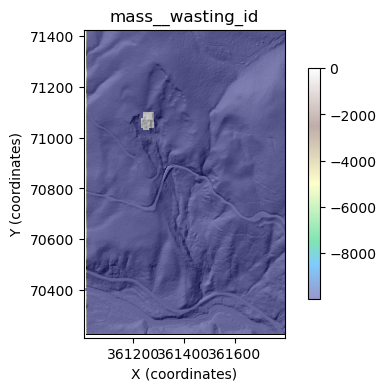

In [4]:
plot_node_field_with_shaded_high_res_dem(mg, mg_hs = mg_hs, field = 'mass__wasting_id',plot_name = 'high_res',
                                         fontsize = 10,alpha = .5,figsize = (6,4))

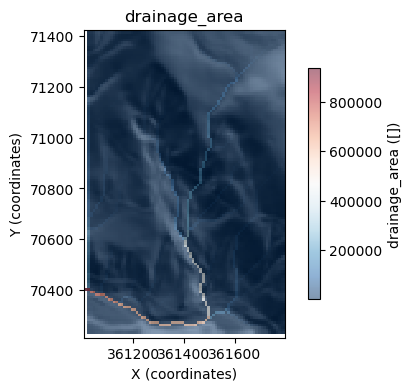

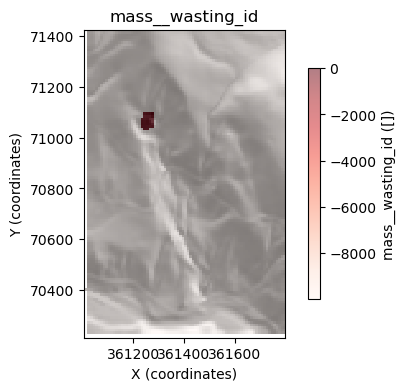

<Figure size 640x480 with 0 Axes>

In [5]:
#%% use DEM to create other needed fields
# flow accumulater to get contributing area to each grid cell
fa = FlowAccumulator(mg, 
                      'topographic__elevation',
                      flow_director='FlowDirectorD8')
fa.run_one_step()
# fill depressions to correct surface area determination
df_4 = DepressionFinderAndRouter(mg)
df_4.map_depressions()
# landlab built in hillshade
mg.at_node['hillshade'] = mg.calc_hillshade_at_node(elevs=z, alt=37., az=210.)

# vissually check inputs
plot_node_field_with_shaded_dem(mg,field = 'drainage_area', fontsize = 10,cmap = 'RdBu_r',alpha = .5,figsize = (6,4))
plot_node_field_with_shaded_dem(mg,field = 'mass__wasting_id', fontsize = 10,cmap = 'Reds',alpha = .5, figsize = (6,4))
plt.figure()
# save an copy of the initial elevation for dem differencing
_ = mg.add_field('topographic__initial_elevation',
                    mg.at_node['topographic__elevation'],
                    at='node',
                    copy = True)
# multiflow direction for MWRu
# need to delete d8 flow direction
mg.delete_field(loc = 'node', name = 'flow__sink_flag')
mg.delete_field(loc = 'node', name = 'flow__link_to_receiver_node')
mg.delete_field(loc = 'node', name = 'flow__receiver_node')
mg.delete_field(loc = 'node', name = 'topographic__steepest_slope')
# run flow director, add slope and receiving node fields
fd = FlowDirectorMFD(mg, diagonals=True,
                      partition_method = 'slope')
fd.run_one_step()

### set model parameters and instantiate MWR!!!!

In [6]:

# debris flow control parameters
# how is the volume released
npu = [1] # sL = [8,10,25] # number of pulses, list for each landslide
nid = [1] #[5,5,5] # delay between pulses (iterations), list for each landslide
SD = params['SD'][2]
Sc = params['slpc'][2]
attributes = ['particle__diameter']

mw_dict = {'critical slope':[Sc], 'threshold flux':SD,
            'scour coefficient':cs, 'scour exponent':eta,
            'effective particle diameter':Pd, 'vol solids concentration':vs,
            'density solids':ros, 'typical flow thickness, scour':h,
            'typical slope, scour':s, 'max observed flow depth': qsi_max }

release_dict = {'number of pulses':npu, 'iteration delay':nid }

DebrisFlows = MassWastingRunout(mg, mw_dict, 
                                tracked_attributes = attributes,
                                save = False,
                                settle_deposit = settle_deposit,
                                effective_qsi = effective_qsi)# DebrisFlowScourAndDeposition(mg, df_para_dict)

# add a Dp class variable
DebrisFlows.Dp = DebrisFlows._grid.at_node['particle__diameter'].mean()

 running with spatially variable Dp 


### load channel nodes, and look at the observed topographic change caused by the landslide

In [7]:
# get channel nodes and distance between nodes
cl = pd.read_excel(xs_dir+xlsxm,sheet_name = 'cl')
cln = cl['MAJORITY'].values
xsd = cln
dist = profile_distance(mg, xsd)

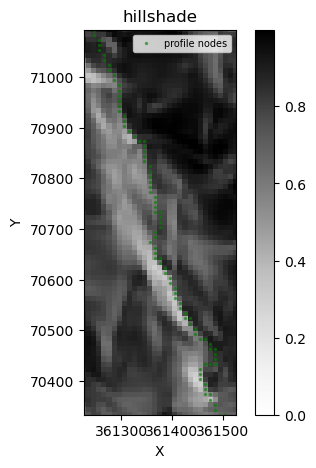

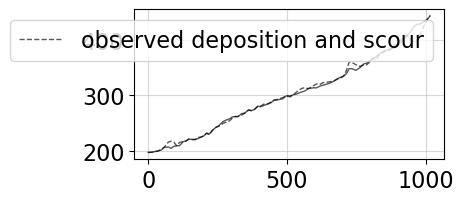

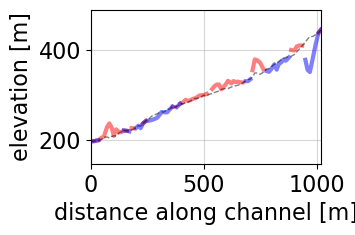

In [8]:
#%% visualize profile and plan view depositional patterns
view_profile_nodes(mg,xsd,'hillshade',cmap = 'Greys')
profile_plot(mg, xsd,aspect = 2,figsize = (4,2), fs = 16)
MWF.profile_deposition_scour(mg, xsd, field = 'dem_dif_o',  ef = 5, aspect = 2,figsize = (4,2), fs = 16)

In [9]:
#%% define the paramete sampling space and parameters for determing the profile metric
# slpc, SD, alpha
channel_nodes = xsd
channel_distance = dist
cL = mg.dx
profile_calib_dict = {"el_l":el_l, "el_h": el_h, "channel_nodes": channel_nodes,
                      "channel_distance":channel_distance, "cL":cL}


In [10]:
#%% instantiate the calibration class
# Initialize the Dream Class
calibrate = MWRu_calibrator(DebrisFlows, params, profile_calib_dict = profile_calib_dict, N_cycles = N_cycles,
                            prior_distribution = "uniform", jump_size = jump_size, alpha_max = alpha_max, alpha_min=alpha_min,
                            plot_tf = True, qsc_constraint = qsc_constraint,
                            method = method, seed = 7)

grain-inertia
E<qsc


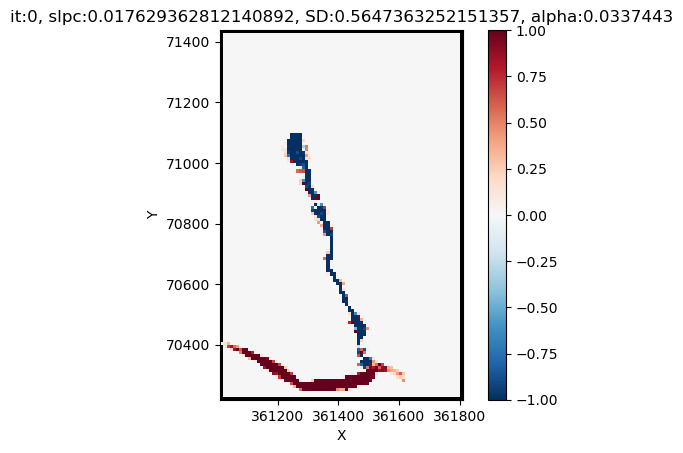

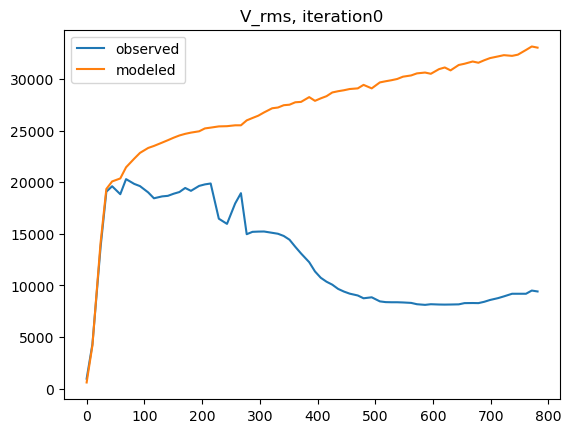

MCMC iteration: 0, likelihood:12.92275, acceptance ratio:1, random value:[ 0.978],jumped to new value
grain-inertia
E<qsc


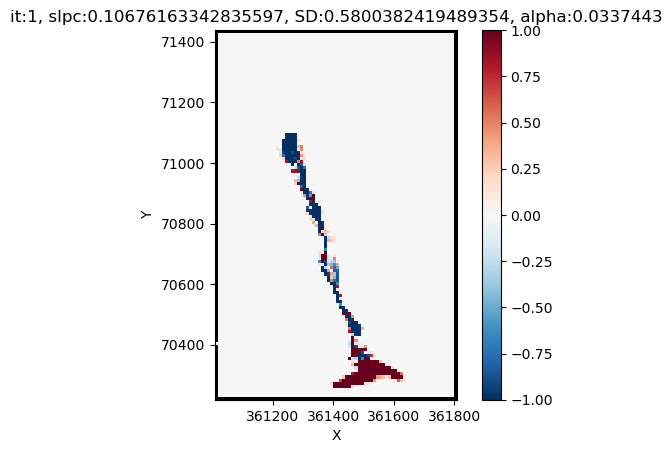

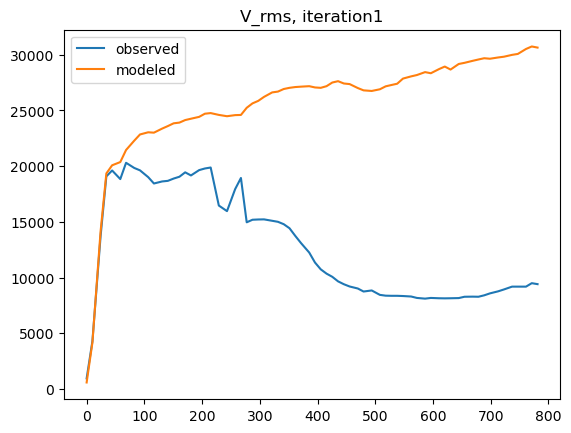

MCMC iteration: 1, likelihood:22.47107, acceptance ratio:1, random value:[ 0.072],jumped to new value
grain-inertia
E<qsc


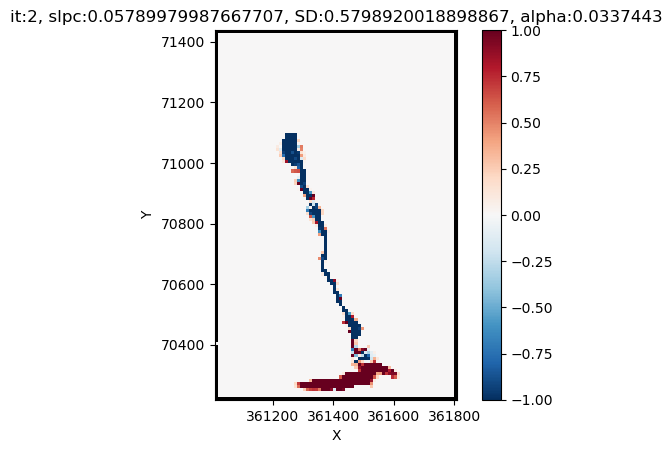

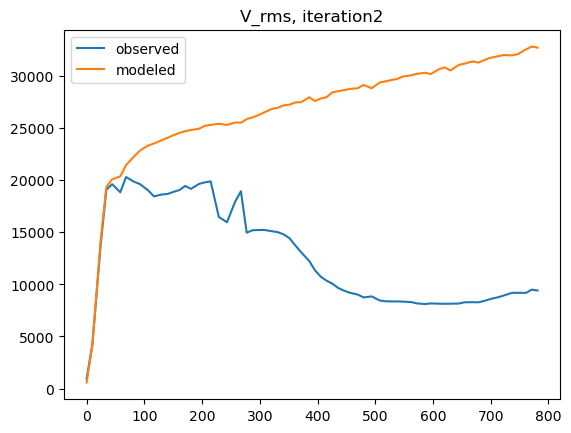

MCMC iteration: 2, likelihood:16.42285, acceptance ratio:0.731, random value:[ 0.679],jumped to new value
grain-inertia
E<qsc


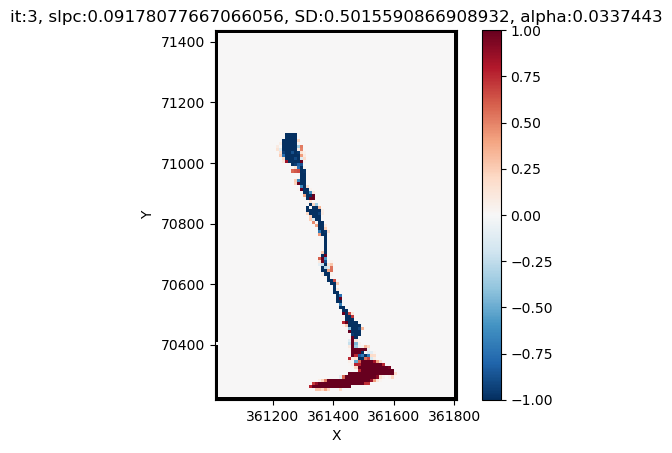

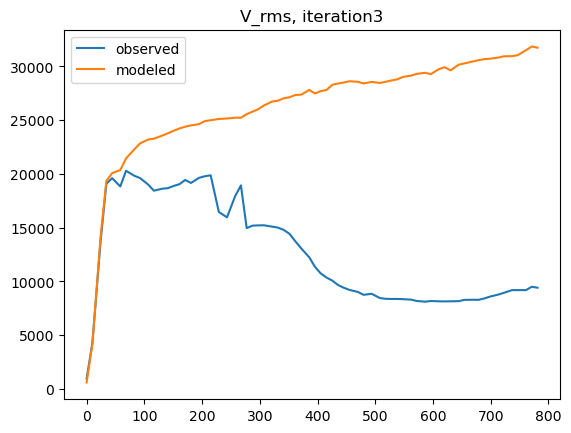

MCMC iteration: 3, likelihood:18.49385, acceptance ratio:1, random value:[ 0.066],jumped to new value
grain-inertia
E<qsc


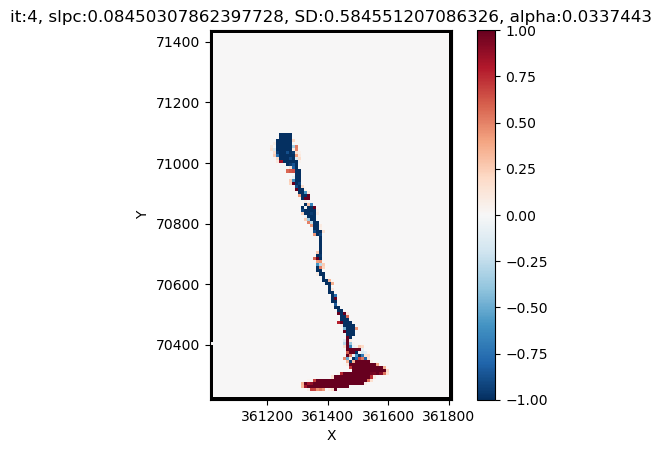

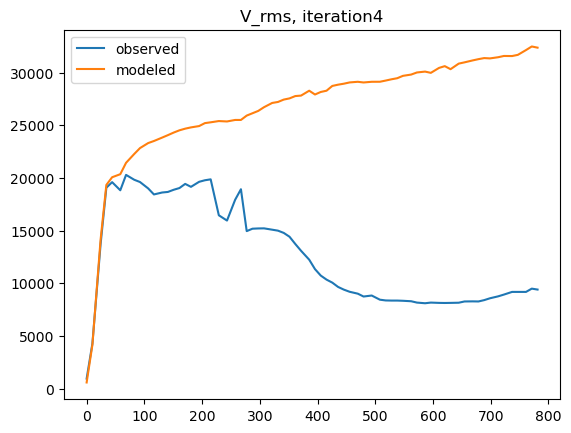

MCMC iteration: 4, likelihood:16.82281, acceptance ratio:0.91, random value:[ 0.213],jumped to new value
grain-inertia
E<qsc


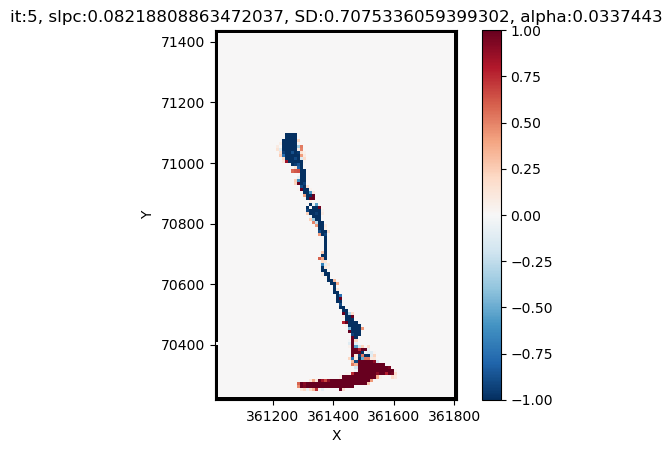

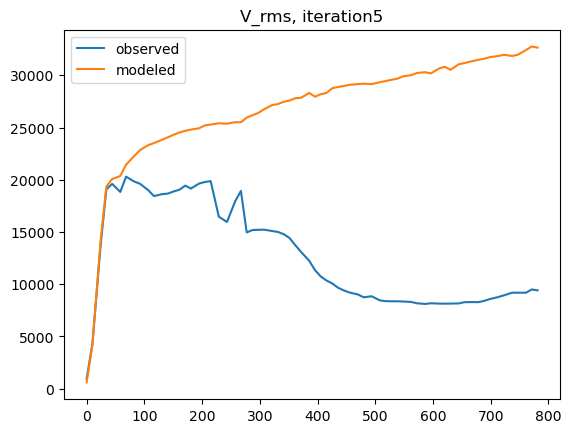

MCMC iteration: 5, likelihood:16.41244, acceptance ratio:0.976, random value:[ 0.025],jumped to new value
grain-inertia
E<qsc


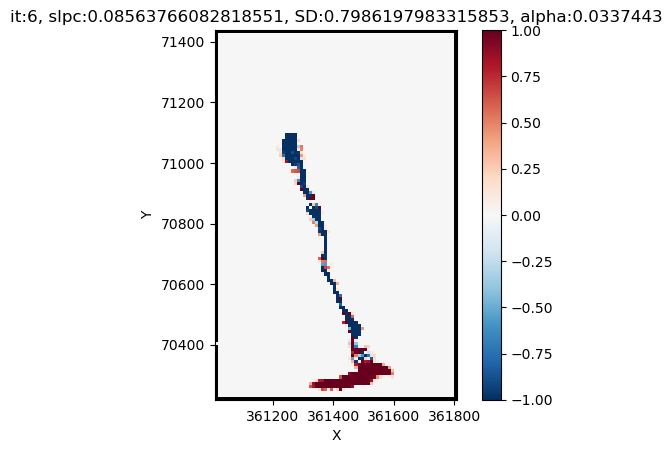

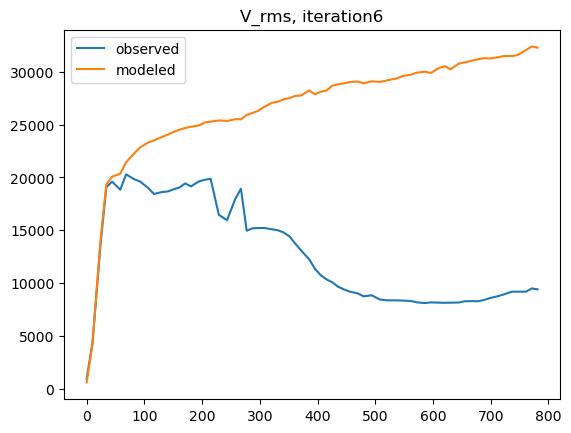

MCMC iteration: 6, likelihood:16.45844, acceptance ratio:1, random value:[ 0.23],jumped to new value
grain-inertia
E<qsc


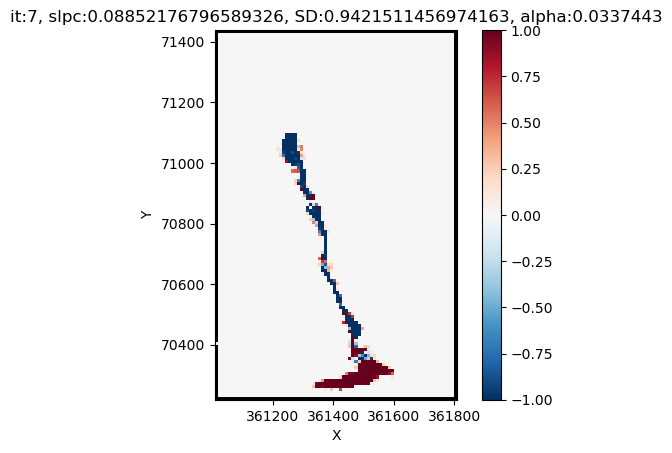

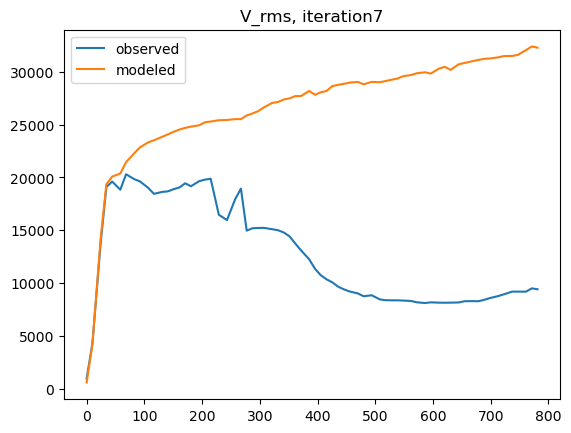

MCMC iteration: 7, likelihood:16.67358, acceptance ratio:1, random value:[ 0.133],jumped to new value
grain-inertia
E<qsc


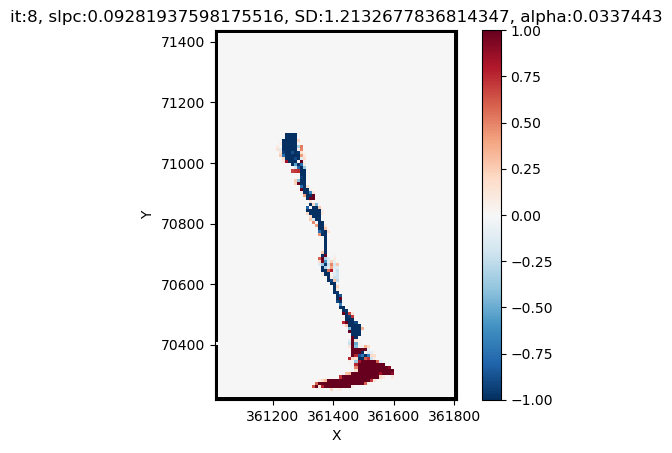

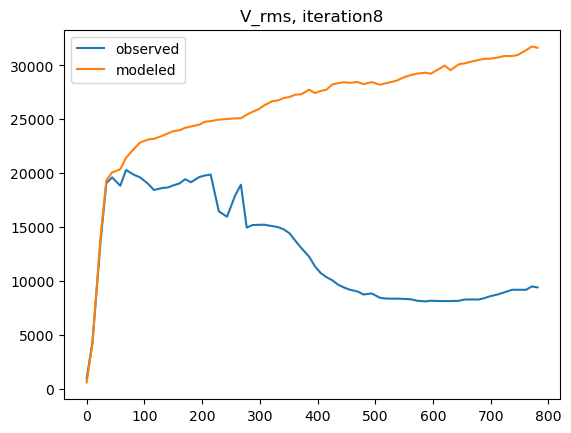

MCMC iteration: 8, likelihood:17.97252, acceptance ratio:1, random value:[ 0.669],jumped to new value
grain-inertia
E<qsc


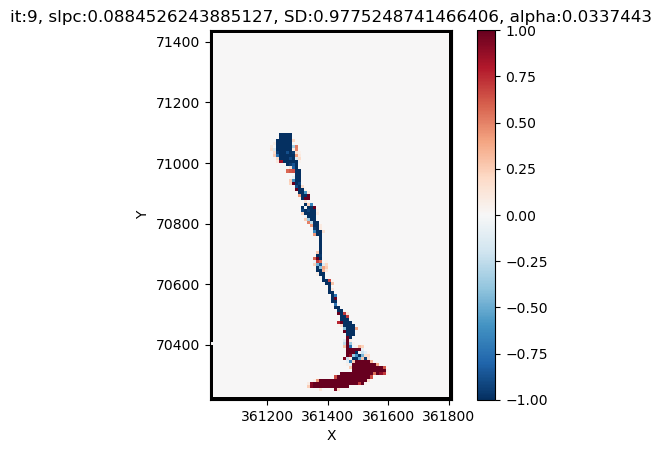

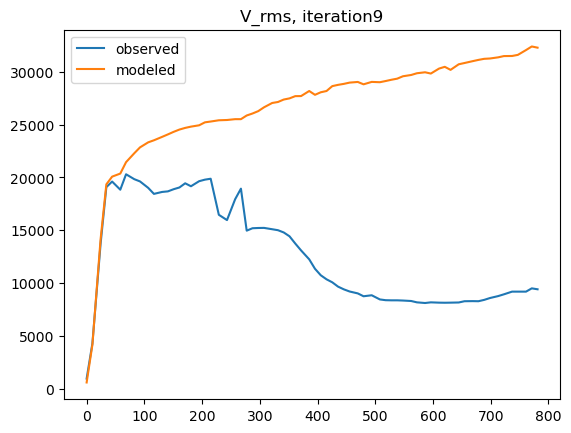

MCMC iteration: 9, likelihood:16.75826, acceptance ratio:0.932, random value:[ 0.491],jumped to new value


In [11]:
#%% calibrate the model 
parameters = calibrate(max_number_of_runs = max_number_of_runs) # change so that calibrator saves model run and lines, then access after is run to create videos

In [12]:
calibrate.mbLdf_m['runout_distance']

0     [781.126983722]
1     [771.126983722]
2     [761.126983722]
3     [746.984848098]
4     [736.984848098]
           ...       
65    [44.1421356237]
66    [34.1421356237]
67    [24.1421356237]
68             [10.0]
69             [-0.0]
Name: runout_distance, Length: 70, dtype: object

### plot the parameter values tested by the calibrator

Text(0, 0.5, 'Sc')

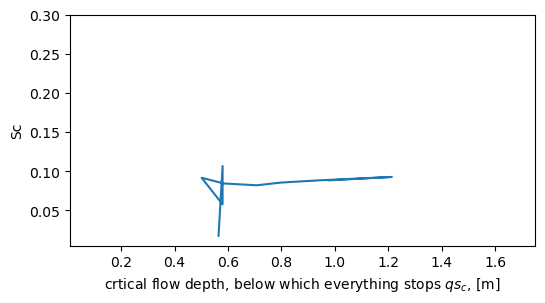

In [13]:
#%% summarize results
results = calibrate.LHvals
results['params'] = str(calibrate.params)
results['mw_dict'] = str(mw_dict)


x_mn = params['SD'][0]
x_mx = params['SD'][1]
y_mn = params['slpc'][0]
y_mx = params['slpc'][1]

# plot jumps
plt.figure(figsize = (6,3))
plt.plot(results['selected_value_SD'], results['selected_value_slpc'])
plt.xlim([x_mn,x_mx])
plt.ylim([y_mn,y_mx])
plt.xlabel('crtical flow depth, below which everything stops $qs_c$, [m]')
plt.ylabel('Sc')


### print best model run parameter values

In [14]:

best = results[results['candidate_posterior'] == results['candidate_posterior'].max()]
print(results.iloc[best['iteration'].values[0]])


iteration                                                                 1
model iterations                                                         97
total_mobilized_volume                                         26406.602925
obs_mean_total_flow                                            12651.563877
prior                                                                     1
omegaT                                                             0.816327
MSE_Qt^1/2                                                         1.180167
Vse^1/2                                                            0.161502
RMSE_pf                                                            2.077899
RMSE_map                                                           0.427068
DTE                                                                0.227502
candidate_posterior                                               22.471072
acceptance_ratio                                                        1.0
random value

### if calibrator is run 2000 times, you get this result:

C:\Users\keckje\Documents\GitHub\code\preevents\paper2\MassWastingRunoutEvaluationFunctions.py:1087: UserWarning: The following kwargs were not used by contour: 'linewidth'
  CS = ax.contour(grid_x,grid_y,grid_z1,np.linspace(np.nanmin(grid_z1),np.nanmax(grid_z1),cntrs), colors='k', linewidth = 0.5)
C:\Users\keckje\Documents\GitHub\code\preevents\paper2\MassWastingRunoutEvaluationFunctions.py:1113: UserWarning: The following kwargs were not used by contour: 'linewidth'
  CS = ax.contour(grid_x,grid_y,grid_z1,np.linspace(np.nanmin(grid_z1),np.nanmax(grid_z1),cntrs), colors='k', linewidth = 0.5)


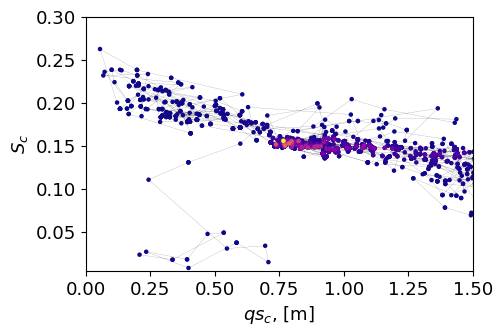

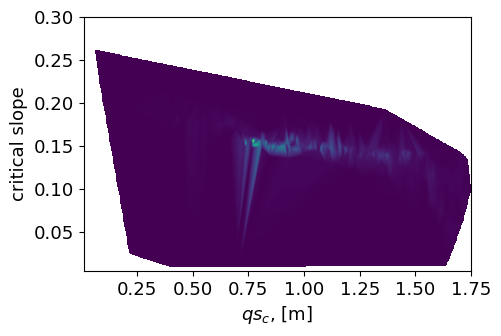

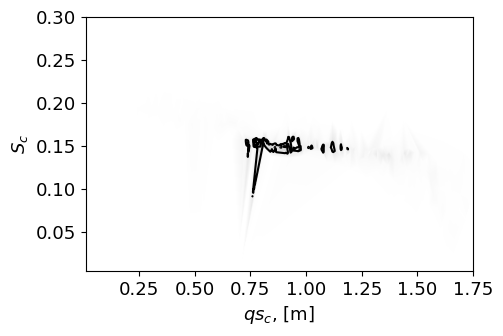

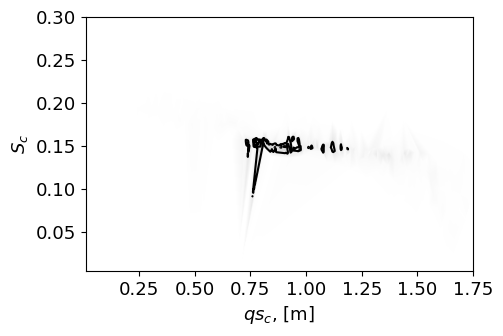

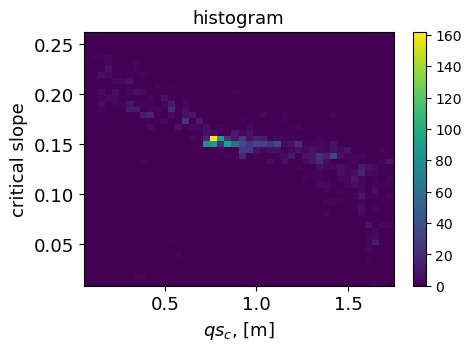

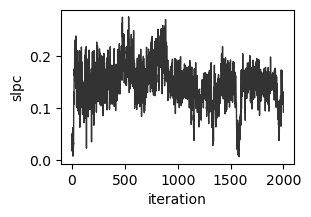

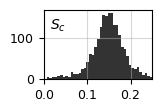

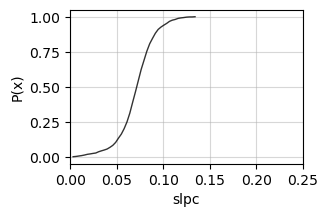

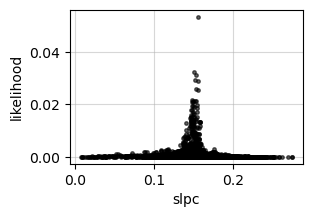

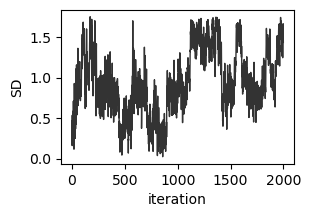

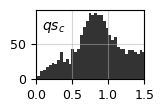

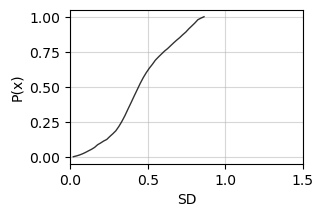

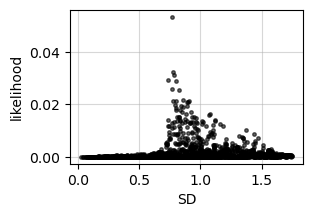

In [15]:
#%% calibration results

csvnm = 's1000_10m_2000_ns_nmcmc.csv'#s1000_10m_200_eta0d2__mcmc.csv'#'s1000_10m_2000_omega_eta0d2__mcmc.csv' #'s1000_22_2000_0d15_mcmc.csv'
# location of calibration output
mdir = 'D:/UW_PhD/PreeventsProject/Paper_2_MWR/RunoutValidation/S1000/output/MCMC_v1/'

results, best, sum_dict, params, mw_dict = MWF.calibration_results(mdir, csvnm, aspect = 'auto', fs = 13, cntrs = 6, figsize = (5,3.3),
                        save = True, svnm = 'example', wdir = 'D:/temp/', labloc = [[0.05,0.75],[0.05,0.75]])  